<a href="https://colab.research.google.com/github/nanditanarendar/Pulsar_Glitches_Thesis/blob/main/c(t)_trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ---------------- Constants ----------------
b0 = 2.95384
b1 = 0.01126
b2 = 0.27421
b3 = 3.42704
b5 = 1
b4 = 0.33854

In [ ]:
class CurvedEOS:
    """
    Curved-spacetime EOS with both numeric and analytic dP/dn.
    - numeric derivative (finite difference) is used by default
    - analytic derivative is used only as a fallback
    """

    def __init__(self, c=0.0):
        self.c = float(c)

    def pressure(self, n, phi):
        # Ensure scalar and non-negative n
        n = max(float(n), 0.0)
        phi = float(phi)

        bn = b2 * n
        # safe fractional powers (bn >= 0)
        bn_13 = bn**(1.0/3.0) if bn >= 0.0 else 0.0
        bn_23 = bn**(2.0/3.0) if bn >= 0.0 else 0.0
        root = np.sqrt(bn_23 + 1.0)

        term1 = root * (2.0 * bn - 3.0 * bn_13)
        term2 = 3.0 * np.log(bn_13 + root) if (bn_13 + root) > 0 else 0.0

        term3 = - self.c * (bn**2)    # extra term c * (bn)^2

        P0 = (b3 / 8.0) * (term1 + term2 + term3)
        return float(np.exp(phi) * P0)

    def energy_density(self, n, phi):
        n = max(float(n), 0.0)
        phi = float(phi)

        bn = b2 * n
        root = np.sqrt(bn**(2.0/3.0) + 1.0) if bn >= 0.0 else 1.0
        # rho = -P + exp(phi) * (b3 * root * bn)
        return float(-self.pressure(n, phi) + np.exp(phi) * (b3 * root * bn))

    def dP_dn_analytic(self, n, phi):
        """
        Analytic derivative of P wrt n (returns ∂P/∂n at fixed phi).
        """
        n = max(float(n), 0.0)
        phi = float(phi)

        bn = b2 * n
        bn_23 = (bn)**(2.0/3.0) if bn >= 0.0 else 0.0
        root = np.sqrt(bn_23 + 1.0)

        # base analytic derivative of P0(n)
        dP0dn_base = (b3 / 3.0) * (bn_23 / root) if root > 0 else 0.0

        # derivative of term3 = c * (bn)^2
        # d/dn [ (bn)^2 ] = 2 * (bn) * d(bn)/dn = 2 * bn * b2
        dP0dn_extra = - 2.0 * self.c * (bn) * b2

        dP0dn = dP0dn_base + dP0dn_extra
        return float(np.exp(phi) * dP0dn)

    def dP_dn_numeric(self, n, phi, eps_rel=1e-8):
        """
        Numeric central finite-difference derivative:
        (∂P/∂n)_phi = exp(phi) * dP0/dn, computed by central difference on P0.
        This mirrors your old derivative helper.
        """
        n = float(n)
        phi = float(phi)
        pre = np.exp(phi)

        # h chosen relative to n, but avoid extremely small h
        h = max(1e-12, eps_rel * max(1.0, abs(n)))
        n_minus = max(n - h, 0.0)
        n_plus = n + h

        # P0 = P(n,phi) / exp(phi)
        Pp0 = (self.pressure(n_plus, phi) / pre)
        Pm0 = (self.pressure(n_minus, phi) / pre)

        # avoid division by zero if n_plus == n_minus
        denom = (n_plus - n_minus)
        if denom == 0.0:
            return float(self.dP_dn_analytic(n, phi))

        dP0dn = (Pp0 - Pm0) / denom
        dPdn = pre * dP0dn
        return float(dPdn)

    def dP_dn(self, n, phi):
        """
        Primary method used by TOV:
        - first try numeric derivative
        - if numeric is not finite or too small, fallback to analytic
        """
        # numeric first
        try:
            dnum = float(self.dP_dn_numeric(n, phi))
        except Exception:
            dnum = float('nan')

        # decide if numeric is acceptable
        if (not np.isfinite(dnum)) or (abs(dnum) < 1e-16):
            # fallback to analytic
            dan = float(self.dP_dn_analytic(n, phi))
            # if analytic also fails, return a safe small positive number
            if (not np.isfinite(dan)) or (abs(dan) < 1e-20):
                return 1.0
            return dan

        return dnum

    def dP_dphi(self, n, phi):
        # exact: ∂P/∂phi = P for P = exp(phi) * P0(n)
        return float(self.pressure(n, phi))

In [ ]:
def tov_background(r, y, eos):
    m, phi, n = y

    if n <= 0.0:
        return [0.0, 0.0, 0.0]

    P   = eos.pressure(n, phi)
    rho = eos.energy_density(n, phi)

    dmdr = b1 * r**2 * rho

    Nr = 0.5 * b0 * (m + b1 * r**3 * P)
    Dr = r * (r - b0 * m)
    if abs(Dr) < 1e-12:
        Dr = np.sign(Dr) * 1e-12 if Dr != 0 else 1e-12

    dphidr = Nr / Dr

    dPdn   = eos.dP_dn(n, phi)
    dPdphi = eos.dP_dphi(n, phi)

    dndr = - ((rho + P + dPdphi) * dphidr) / dPdn

    return [dmdr, dphidr, dndr]

In [ ]:
def integrate_star_curved(
    nc,
    eos,
    phi_bracket=(-1.0, 0.0),
    n_min=1e-6,
    r_max=100.0,
    max_step=0.5,
    r0=1e-2,
    rtol=1e-6,
    atol=1e-8,
    xtol=1e-8,
    maxiter=50,
    return_profile=True,   # if True, return the solve_ivp solution object
):

    nc = float(nc)
    if nc <= n_min:
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)

    # Event: stop when n hits n_min from above
    def surface_event(r, y):
        return y[2] - n_min
    surface_event.terminal = True
    surface_event.direction = -1

    # Integrate outward for a given trial phi_c
    def integrate_outward(phi_c):
        phi_c = float(phi_c)

        rho_c = eos.energy_density(nc, phi_c)
        m0 = (b1 * r0**3 * rho_c) / 3.0
        y0 = [float(m0), float(phi_c), float(nc)]

        sol = solve_ivp(
            fun= lambda r, y:tov_background(r, y, eos),          # IMPORTANT: 3-variable background ODE
            t_span=(r0, r_max),
            y0=y0,
            method="RK45",
            max_step=max_step,
            rtol=rtol,
            atol=atol,
            events=surface_event,
            dense_output=True,           # IMPORTANT for later w-solve
        )

        if sol.t_events is not None and len(sol.t_events[0]) > 0:
            r_surf = float(sol.t_events[0][0])
            m_surf = float(sol.y_events[0][0][0])
            phi_evol_R = float(sol.y_events[0][0][1])
            return m_surf, r_surf, phi_evol_R, sol

        # fallback: if integration ended "near surface"
        if sol.success and sol.y[2, -1] < n_min * 10:
            r_surf = float(sol.t[-1])
            m_surf = float(sol.y[0, -1])
            phi_evol_R = float(sol.y[1, -1])
            return m_surf, r_surf, phi_evol_R, sol

        raise RuntimeError("Surface event did not trigger and star did not end cleanly.")

    cache = {}

    def mismatch(phi_c):
        try:
            m_surf, r_surf, phi_evol_R, sol = integrate_outward(phi_c)

            arg = 1.0 - (b0 * m_surf) / r_surf
            if (not np.isfinite(arg)) or (arg <= 0.0):
                val = np.nan
                phi_surf = np.nan
            else:
                phi_surf = 0.5 * np.log(arg)
                val = phi_evol_R - phi_surf

            cache["last"] = (m_surf, r_surf, float(phi_c), phi_evol_R, phi_surf, val, sol)
            return float(val)

        except Exception:
            cache["last"] = None
            return np.nan

    a, b = map(float, phi_bracket)
    ya, yb = mismatch(a), mismatch(b)

    # brentq needs opposite signs at endpoints
    if (not np.isfinite(ya)) or (not np.isfinite(yb)):
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)
    if np.sign(ya) == np.sign(yb):
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)

    sol_root = root_scalar(
        mismatch,
        bracket=(a, b),
        method="brentq",
        xtol=xtol,
        maxiter=maxiter
    )

    if not sol_root.converged:
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)

    phi_c_star = float(sol_root.root)

    # final clean evaluation at phi_c_star
    try:
        m_surf, r_surf, phi_evol_R, sol_bg = integrate_outward(phi_c_star)
        arg = 1.0 - (b0 * m_surf) / r_surf
        if arg <= 0.0:
            return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)
        phi_surf = 0.5 * np.log(arg)

        if return_profile:
            return float(m_surf), float(r_surf), phi_c_star, float(phi_evol_R), float(phi_surf), sol_bg
        else:
            return float(m_surf), float(r_surf), phi_c_star, float(phi_evol_R), float(phi_surf)

    except Exception:
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)

In [ ]:
def integrate_frame_dragging(
    sol_bg,              # returned from integrate_star_curved(..., return_profile=True)
    R,                   # star radius from background solve
    Omega,               # fluid angular speed (constant parameter)
    eos,
    w_bracket=None,      # default (0, Omega) if None
    r0=1e-2,
    max_step=0.5,
    rtol=1e-8,
    atol=1e-10,
    xtol=1e-10,
    maxiter=80
):

    if w_bracket is None:
        w_bracket = (0.0, float(Omega))

    R = float(R)
    Omega = float(Omega)
    a, b = map(float, w_bracket)

    # --- Frame-dragging ODE on fixed background ---
    def frame_ode(r, y):
        w, q = y  # q = dw/dr

        # background at this r
        m, phi, n = sol_bg.sol(r)

        # Need phi'(r) and nu'(r) to build j'/j
        P   = eos.pressure(n, phi)
        rho = eos.energy_density(n, phi)

        dmdr = b1 * r**2 * rho

        Nr = 0.5 * b0 * (m + b1 * r**3 * P)
        Dr = r * (r - b0 * m)
        if abs(Dr) < 1e-12:
            Dr = np.sign(Dr) * 1e-12 if Dr != 0 else 1e-12
        dphidr = Nr / Dr

        # e^{-2 nu} = 1 - b0*m/r  (your scaling of 1 - 2GM/r)
        f = 1.0 - (b0 * m) / r
        if (not np.isfinite(f)) or (f <= 0.0):
            return [0.0, 0.0]

        # nu' from nu = -0.5 ln(f)
        dnudr = 0.5 * b0 * (r * dmdr - m) / (r**2 * f)

        # alpha = nu' + phi'
        alpha = dnudr + dphidr

        # First-order system
        dwdr = q
        dqdr = ( (-4.0/r * q) + (alpha * q) + ((4.0/r) * alpha * (w - Omega)) )

        # optional debug scaling knob
        #dwdr /= b5
        #dqdr /= b5

        return [float(dwdr), float(dqdr)]

    # --- Integrate w outward for a trial w_c ---
    def integrate_w_outward(w_c):
        y0 = [float(w_c), 0.0]  # regularity: w'(0)=0

        sol_w = solve_ivp(
            fun=frame_ode,
            t_span=(r0, R),
            y0=y0,
            method="RK45",
            max_step=max_step,
            rtol=rtol,
            atol=atol,
            dense_output=False
        )

        if (not sol_w.success) or (sol_w.t[-1] < 0.999*R):
            raise RuntimeError("w integration failed or did not reach R")

        w_R = float(sol_w.y[0, -1])
        wprime_R = float(sol_w.y[1, -1])
        return w_R, wprime_R, sol_w

    # --- Mismatch y2(w_c) ---
    # Surface condition: w'(R) = -3 w(R)/R
    # Equivalent mismatch: y2 = w(R) + (R/3)*w'(R) = 0.
    def mismatch_w(w_c):
        w_R, wprime_R, _ = integrate_w_outward(w_c)
        return w_R + (R/3.0) * wprime_R

    ya = mismatch_w(a)
    yb = mismatch_w(b)

    # If no sign change, switch to a non-bracketing method (secant) by giving two guesses.
    # This avoids "f(a) and f(b) must have different signs" errors.
    if np.isfinite(ya) and np.isfinite(yb) and (np.sign(ya) != np.sign(yb)):
        sol_root = root_scalar(
            mismatch_w,
            bracket=(a, b),
            method="brentq",
            xtol=xtol,
            maxiter=maxiter
        )
    else:
        sol_root = root_scalar(
            mismatch_w,
            x0=a,
            x1=b if b != a else a + 1e-6,
            method="secant",
            xtol=xtol,
            maxiter=maxiter
        )

    if not sol_root.converged:
        return 0.0, 0.0, 0.0, 0.0, None

    w_c_star = float(sol_root.root)
    w_R, wprime_R, sol_w = integrate_w_outward(w_c_star)

    J = b4 * w_R * R**3

    return w_c_star, w_R, wprime_R, J, sol_w

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Pulsar parameters (Vela-like)
# -----------------------------
F0 = 11.1946499395       # Hz
F1 = -1.5666e-11        # Hz/s
F2 = 1.0280e-21         # Hz/s^2 (small)

Omega0 = 2.0 * np.pi * F0   # reference angular velocity (rad/s)

print(f"Reference Omega = {Omega0:.6f} rad/s")

Reference Omega = 70.338060 rad/s


In [ ]:
# -----------------------------
# Glitch 3 (single-glitch study)
# -----------------------------
g1 = {
    "tg": 40280.0,                         # MJD
    "delta_nu_total": 2.338e-6 * F0,       # Hz
    "Q": 0.001980,
    "delta_nudot_p": 1.01e-2 * F1,         # Hz/s
    "tau_days": 10.0
}

# -----------------------------
# Glitch 4
# -----------------------------
g2 = {
    "tg": 41192,
    "delta_nu_total": (2.047e-6 * F0),
    "Q": 0.1,
    "delta_nudot_p": (1.48e-2 * F1),
    "tau_days": 4.0
}

# -----------------------------
# Time window around glitch
# -----------------------------
window_days = 300.0   # ± window
n_points = 10000       # target resolution

t_start = g1["tg"] - window_days
t_end   = g1["tg"] + window_days

t = np.linspace(t_start, t_end, n_points)
sec_per_day = 86400.0

print(f"Time window: {t_start:.1f} – {t_end:.1f} MJD")
print(f"Number of points: {len(t)}")

Time window: 39980.0 – 40580.0 MJD
Number of points: 10000


In [ ]:
# -----------------------------
# Secular spin evolution
# -----------------------------
t0 = g1["tg"]   # reference epoch at glitch
dt_sec = (t - t0) * sec_per_day

nu_secular = (
    F0
    + F1 * dt_sec
    + 0.5 * F2 * dt_sec**2
)

def glitch_nu(t, tg, delta_nu_total, Q, delta_nudot_p=0.0, tau_days=None):
    H = np.heaviside(t - tg, 0.0)
    dt_sec = (t - tg) * sec_per_day

    delta_nu_p = (1.0 - Q) * delta_nu_total
    nu_g = delta_nu_p + delta_nudot_p * dt_sec

    if tau_days is not None and Q > 0.0:
        nu_g += Q * delta_nu_total * np.exp(-(t - tg) / tau_days)

    return H * nu_g


nu_glitch = glitch_nu(t, **g1)
nu_total = nu_secular + nu_glitch

In [ ]:
Omega_t = 2.0 * np.pi * nu_total
Delta_Omega = Omega_t[1:] - Omega_t[:-1]
t_mid = 0.5 * (t[1:] + t[:-1])

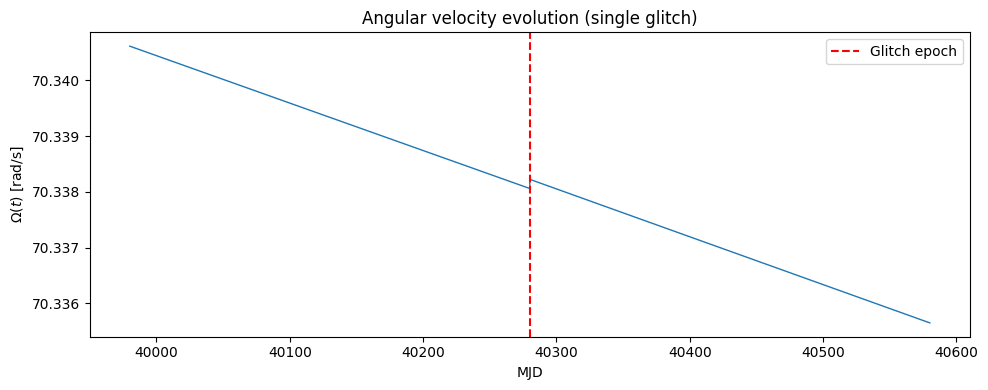

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t, Omega_t, lw=1)
plt.axvline(g1["tg"], color="r", ls="--", label="Glitch epoch")
plt.xlabel("MJD")
plt.ylabel(r"$\Omega(t)$ [rad/s]")
plt.title("Angular velocity evolution (single glitch)")
plt.legend()
plt.tight_layout()
plt.show()

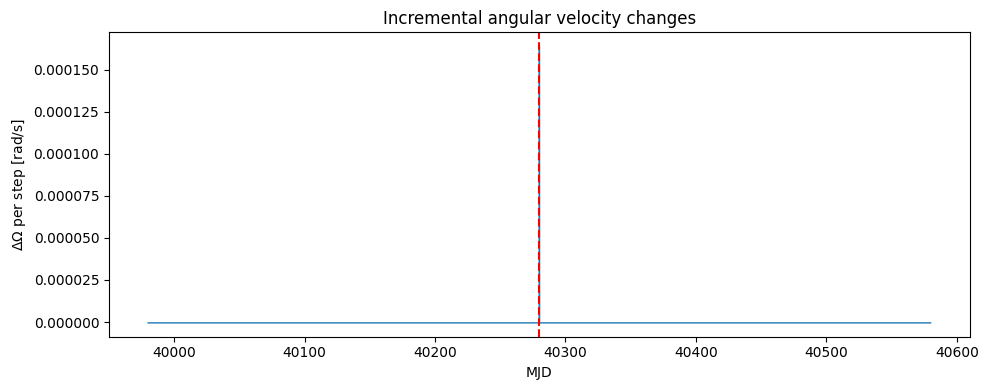

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t_mid, Delta_Omega, lw=1)
plt.axvline(g1["tg"], color="r", ls="--")
plt.xlabel("MJD")
plt.ylabel(r"$\Delta \Omega$ per step [rad/s]")
plt.title("Incremental angular velocity changes")
plt.tight_layout()
plt.show()

In [ ]:
print(Delta_Omega)

[-5.11192397e-07 -5.11192226e-07 -5.11192070e-07 ... -5.14611202e-07
 -5.14611045e-07 -5.14610861e-07]


In [ ]:
# -----------------------------
# Phase B: Fixed stellar targets
# -----------------------------
M_target = 0.7          # solar masses
Omega_ref = 2.0 * np.pi * F0   # rad/s (same as Phase A)
print(f"Target mass = {M_target} Msun")
print(f"Reference Omega = {Omega_ref:.6f} rad/s")

Target mass = 0.7 Msun
Reference Omega = 70.338060 rad/s


In [ ]:
# -----------------------------
# Find reference star at c = 0
# -----------------------------
eos0 = CurvedEOS(c=0.0)

nc_grid = np.logspace(-3, 1, 80)

M_list, R_list, sol_list, nc_list = [], [], [], []

for nc in nc_grid:
    M, R, _, _, _, sol_bg = integrate_star_curved(
        nc=nc,
        eos=eos0,
        return_profile=True
    )
    if M > 0:
        M_list.append(M)
        R_list.append(R)
        sol_list.append(sol_bg)
        nc_list.append(nc)

M_list = np.array(M_list)
R_list = np.array(R_list)
nc_list = np.array(nc_list)

In [ ]:
from scipy.interpolate import interp1d

nc_of_M = interp1d(M_list, nc_list, kind="linear", fill_value="extrapolate")
R_of_M  = interp1d(M_list, R_list,  kind="linear", fill_value="extrapolate")

nc_ref = float(nc_of_M(M_target))
R_ref  = float(R_of_M(M_target))

print(f"Reference nc = {nc_ref:.4e} fm^-3")
print(f"Reference R  = {R_ref:.3f} km")

Reference nc = 6.8641e-01 fm^-3
Reference R  = 13.223 km


In [ ]:
M0, R0, _, _, _, sol_bg0 = integrate_star_curved(
    nc=nc_ref,
    eos=eos0,
    return_profile=True
)

# -----------------------------
# Compute reference J at c = 0
# -----------------------------
_, wR0, _, J_ref, _ = integrate_frame_dragging(
    sol_bg=sol_bg0,
    R=R0,
    Omega=Omega_ref,
    eos=eos0
)

print(f"Reference angular momentum J = {J_ref:.6e}")

Reference angular momentum J = 1.892039e+03


In [ ]:
# -----------------------------
# Small EOS perturbation
# -----------------------------
c_ref = 1e-7
print(f"Using c_ref = {c_ref:.1e}")

Using c_ref = 1.0e-07


In [ ]:
# -----------------------------
# EOS with small perturbation
# -----------------------------
eos1 = CurvedEOS(c=c_ref)

# Recompute background star
M1, R1, _, _, _, sol_bg1 = integrate_star_curved(
    nc=nc_ref,
    eos=eos1,
    return_profile=True
)

In [ ]:
from scipy.optimize import root_scalar

def J_mismatch(Omega_trial):
    _, _, _, J_trial, _ = integrate_frame_dragging(
        sol_bg=sol_bg1,
        R=R1,
        Omega=Omega_trial,
        eos=eos1
    )
    return J_trial - J_ref

sol_Omega = root_scalar(
    J_mismatch,
    bracket=(0.5 * Omega_ref, 1.5 * Omega_ref),
    method="brentq"
)

Omega_c = sol_Omega.root

In [ ]:
# -----------------------------
# Sensitivity calibration
# -----------------------------
Delta_Omega_c = Omega_c - Omega_ref
sensitivity = Delta_Omega_c / c_ref

print(f"ΔΩ(c_ref) = {Delta_Omega_c:.6e} rad/s")
print(f"dΩ/dc ≈ {sensitivity:.6e} (rad/s) per unit c")

ΔΩ(c_ref) = 5.809955e-06 rad/s
dΩ/dc ≈ 5.809955e+01 (rad/s) per unit c


In [ ]:
# -----------------------------
# Phase C: Sensitivity (from Phase B)
# -----------------------------
sensitivity = 5.809955e+01   # rad/s per unit c

print(f"Using sensitivity dΩ/dc = {sensitivity:.6e}")
# -----------------------------
# Compute c(t)
# -----------------------------
c_t = Delta_Omega / sensitivity

print("c(t) statistics:")
print(f"  min c = {np.min(c_t):.3e}")
print(f"  max c = {np.max(c_t):.3e}")
print(f"  mean c = {np.mean(c_t):.3e}")

Using sensitivity dΩ/dc = 5.809955e+01
c(t) statistics:
  min c = -8.906e-09
  max c = 2.822e-06
  mean c = -8.545e-09


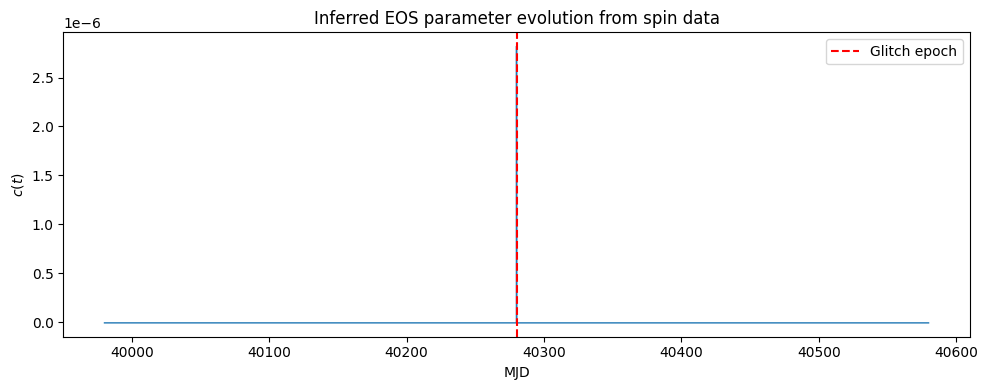

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t_mid, c_t, lw=1)
plt.axvline(g1["tg"], color="r", ls="--", label="Glitch epoch")
plt.xlabel("MJD")
plt.ylabel(r"$c(t)$")
plt.title("Inferred EOS parameter evolution from spin data")
plt.legend()
plt.tight_layout()
plt.show()

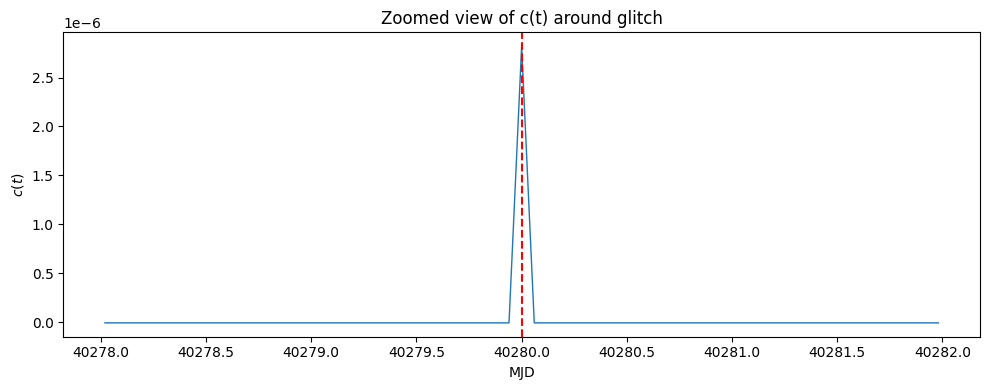

In [ ]:
zoom_days = 2
mask = np.abs(t_mid - g1["tg"]) < zoom_days

plt.figure(figsize=(10, 4))
plt.plot(t_mid[mask], c_t[mask], lw=1)
plt.axvline(g1["tg"], color="r", ls="--")
plt.xlabel("MJD")
plt.ylabel(r"$c(t)$")
plt.title("Zoomed view of c(t) around glitch")
plt.tight_layout()
plt.show()

In [ ]:
print(c_t)

[-8.79856035e-09 -8.79855741e-09 -8.79855472e-09 ... -8.85740426e-09
 -8.85740157e-09 -8.85739839e-09]


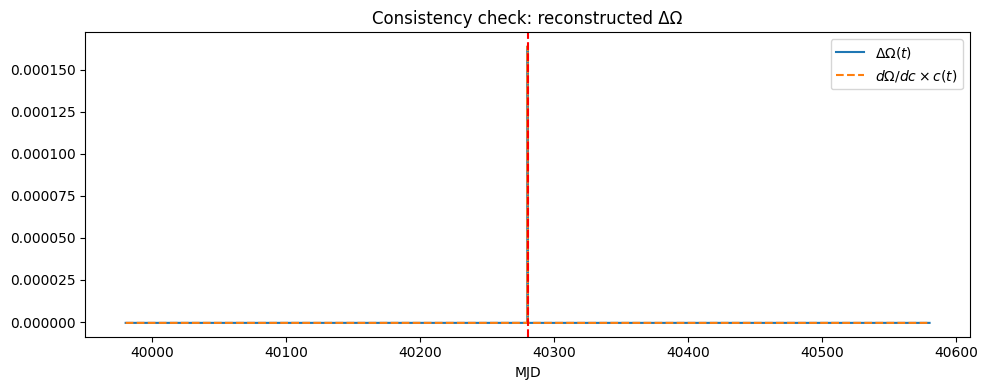

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t_mid, Delta_Omega, label=r"$\Delta \Omega(t)$")
plt.plot(t_mid, sensitivity * c_t, "--", label=r"$d\Omega/dc \times c(t)$")
plt.axvline(g1["tg"], color="r", ls="--")
plt.xlabel("MJD")
plt.legend()
plt.title("Consistency check: reconstructed ΔΩ")
plt.tight_layout()
plt.show()